**<font size="7">BMI Basics for NextGen Workshop Demo</font>**  
<font size="5">Part of the 2023 CIROH Training and Developers Conference</font>  
<font size="4">2023-05-16 through 2023-05-18  
University of Utah  
Salt Lake City, UT</font>  

Keith Jennings  
<kjennings@lynker.com> | <keith.jennings@noaa.gov>  
<https://github.com/SnowHydrology>  
Lynker, NOAA Affiliate

# 1 Introduction

This Jupyter notebook details how to run one model and then couple two models using Basic Model Interface (BMI) functions.

## 1.1 BMI Background

The Community Surface Dynamics Modeling System ([CSDMS](https://csdms.colorado.edu/)) group at the University of Colorado Boulder develops and maintains BMI. You can find further information on the [BMI GitHub page](https://github.com/csdms/bmi) or on the [CSDMS Wiki](https://csdms.colorado.edu/wiki/BMI).

The two reference papers for BMI are:

- *Hutton, E.W., Piper, M.D., and Tucker, G.E., 2020. The Basic Model Interface 2.0: A standard interface for coupling numerical models in the geosciences. Journal of Open Source Software, 5(51), 2317, https://doi.org/10.21105/joss.02317.*
- *Peckham, S.D., Hutton, E.W., and Norris, B., 2013. A component-based approach to integrated modeling in the geosciences: The design of CSDMS. Computers & Geosciences, 53, pp.3-12, http://dx.doi.org/10.1016/j.cageo.2012.04.002.*


I based the two models used in this demo, `snowBMI` and `linearresBMI`, heavily on the `heat` [example](https://github.com/csdms/bmi-example-python) produced by CSDMS. 

## 1.2 What we're going to learn

We're going to first take a look at a temperature index (or degree day) snow model that has an implementation of BMI. We'll explore the different BMI functions and how they standardize many model capabilities that can be quite idiosyncratic across the range of numerical models. Next, we'll see how we can couple the snow model to a linear reservoir model using BMI functions to provide a conceptual treatment of the hydrologic system in a snowy catchment.

# 2 Get the models set up

## 2.1 Requirements

This is a simple bit of Python code developed with Python 3.9 in [PyCharm](https://www.jetbrains.com/pycharm/). The `snowBMI` and `linearresBMI` modules require:

* The [BMI Python bindings](https://github.com/csdms/bmi-python) from CSDMS
  * Follow their instructions to build the bindings
* `numpy`
* `yaml`

Running the example notebook also requires:

* [Jupyter Notebook](https://jupyter.org/)
* `pandas`
* `Matplotlib`

## 2.2 `snowBMI`

The `snowBMI` model is available here: https://github.com/SnowHydrology/snowBMI

You can clone the code by opening a terminal window and running:

`git clone https://github.com/SnowHydrology/snowBMI.git` 

Or, you can download a zip file of the code from GitHub. 

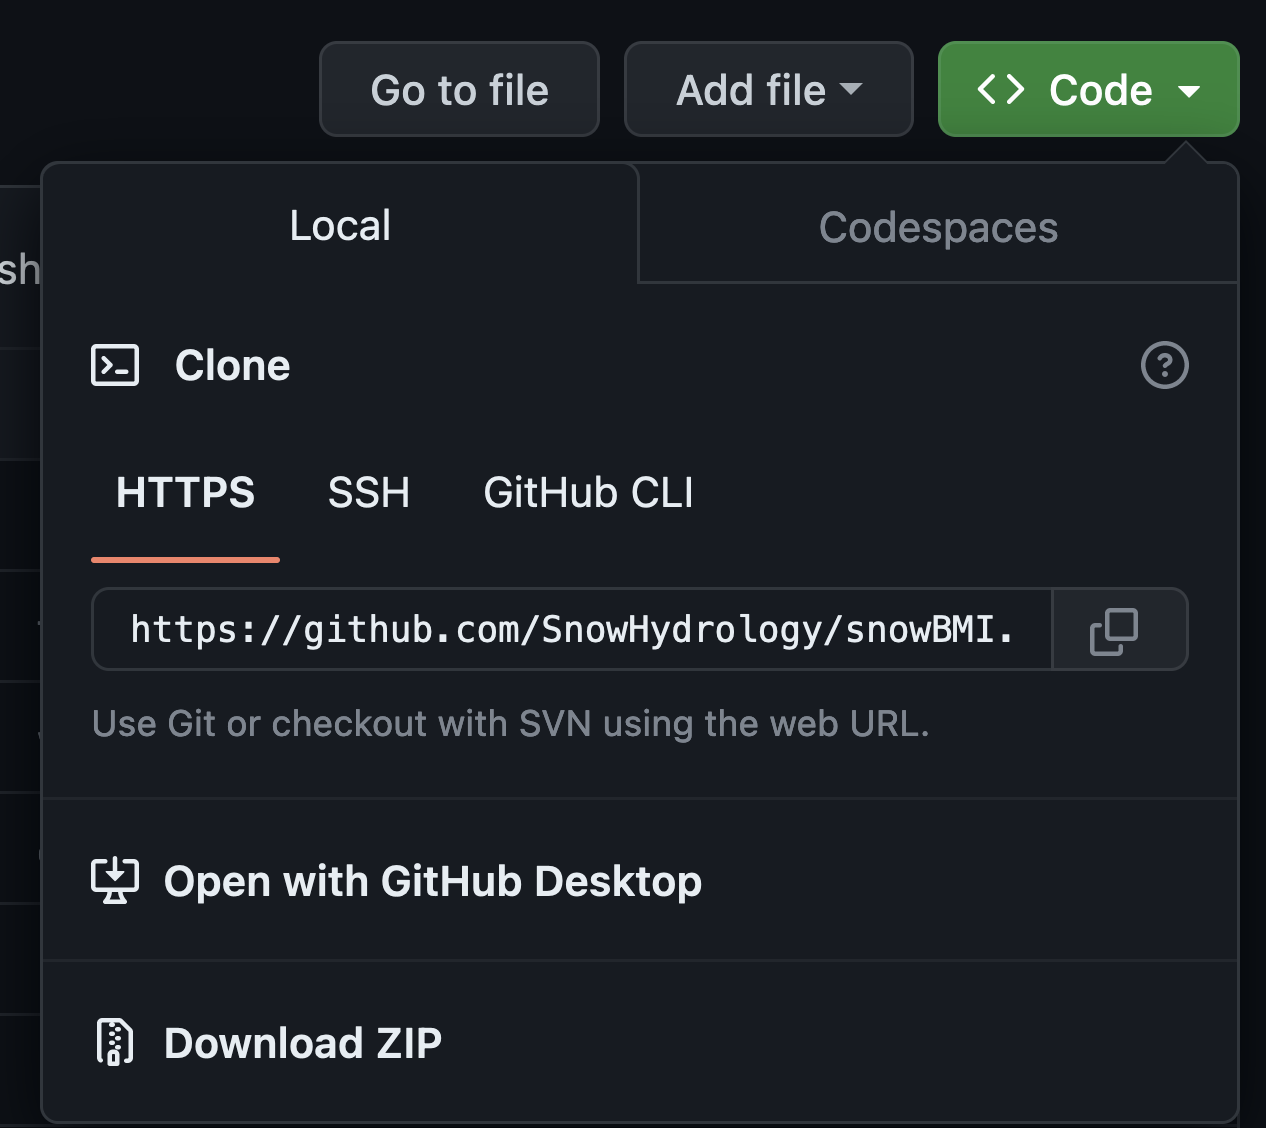

Once you've gotten the code on your machine, install it by going to the main level of the `snowBMI` directory and typing the following into a terminal window:

`pip install -e .`

*Note: pip is included with most newer Python distributions. Note 2: The Python BMI bindings need to be installed before this module.*

## 2.3 `linearresBMI`

To get the `linearresBMI` model, go to: https://github.com/SnowHydrology/linearresBMI/. Then follow the above instructions, but replace `snowBMI` with `linearresBMI`.

# 3 `snowBMI`: let's get under the hood

`snowBMI` is a temperature index snow model, meaning it estimates snowmelt as a function of the number of degrees air temperature is above a melting threshold and a factor that converts that difference to a melt depth. This simple implementation is about as bare bones as you can get. It doesn't account for snow hydrology, any explicit energy states and fluxes, etc.

That being said, I tried to use Python best practices (mostly from the CSDMS heat example) even though I'm really an R guy. 

## 3.1 Model structure
```

├── examples
│   ├── data
│   │   └── snotel_663_data.csv
│   ├── run-model-from-bmi.ipynb
│   └── snow.yaml
├── requirements.txt
├── setup.cfg
├── setup.py
├── snow
│   ├── __init__.py
│   ├── _version.py
│   ├── bmi_snow.py
│   └── snow.py
└── tools
    ├── README.Rmd
    ├── README.md
    └── README_files
        └── figure-gfm
            ├── pressure-1.png
            └── unnamed-chunk-7-1.png
```

Most of the important code is in the `snow/` directory, which contains the BMI functions and the model code. The `examples/` folder includes a configuration file (`snow.yaml`) and example data for running the model. The `tools/` folder has the R code needed to access SNOTEL observations if you want to gather more forcing data.

## 3.2 Source code

All of the hydrologic modeling code is in a function called `solve_snow` in `snow.py`.

Notice that the variables in the function definition are not CSDMS standard names.

``` python
def solve_snow(temp, precip, doy, swe, melt, rain_snow, rs_thresh, snow_thresh_max, rain_thresh_min,
               ddf_max, ddf_min, tair_melt_thresh):
               
    # Assign precipitation phase
    # 0 = snow, 1 = rain
    if rain_snow == 1:
        if temp <= rs_thresh:
            ppt_phase = 0
        else:
            ppt_phase = 1
    elif rain_snow == 2:
        if temp <= snow_thresh_max:
            ppt_phase = 0
        elif temp >= rain_thresh_min:
            ppt_phase = 1
        else:
            ppt_phase = (temp - snow_thresh_max) / (rain_thresh_min - snow_thresh_max)
    else:
        raise RuntimeError("Invalid rain-snow partitioning method")

    # Compute snowfall and rainfall
    snowfall_mm = (1 - ppt_phase) * precip
    rainfall_mm = precip - snowfall_mm

    # Add new snowfall to swe
    np.add(swe, snowfall_mm, out=swe)

    # Compute degree day factor for melt calcs
    ddf = ((ddf_max + ddf_min) / 2) + (np.sin((doy - 81) / 58.09) * ((ddf_max - ddf_min) / 2))

    # Compute potential melt
    if temp > tair_melt_thresh:
        melt_pot_mm = (temp - tair_melt_thresh) * ddf
    else:
        melt_pot_mm = 0

    # Compute total melt knowing melt can't exceed SWE
    melt = np.add(0, min(swe, melt_pot_mm), out=melt)

    # Compute SWE taking melt into account
    swe = np.subtract(swe, melt, swe)

    # Add rainfall to melt
    # Yes, rainfall != melt, but this simple model assumes all rain is a land surface water flux
    melt = np.add(melt, rainfall_mm, out=melt)
    
    return swe, melt
```

## 3.3 A few peeks at BMI

We'll see the output from BMI commands in the following section, but I thought it would be illustrative to see the implementation of a few functions now that we've been introduced to them in the presentation.

### 3.3.1 Initialize

The `initialize` function reads the configuration file to set initial model state and parameter values. The `initialize` function in `snowBMI` includes all of the code needed to set up the model; however, you can also implement an `initialize` function that calls other functions in the model code. I.e. if you have standalone initialize code already, you don't have to move it to BMI--just call the already written function.

The other thing this particular `initialize` function does is map the CSDMS standard names to the model variable names. We also give the UDUNITS-compliant units for each input and output variable. 

``` python
def initialize(self, filename=None):
        """Initialize the model.

        Parameters
        ----------
        filename : str, optional
            Path to name of input file.
        """
        if filename is None:
            self._model = Snow()
        elif isinstance(filename, str):
            with open(filename, "r") as file_obj:
                self._model = Snow.from_file_like(file_obj.read())
        else:
            self._model = Snow.from_file_like(filename)

        self._values = {"atmosphere_water__precipitation_leq-volume_flux": self._model.ppt_mm,
                        "land_surface_air__temperature": self._model.tair_c,
                        "snowpack__liquid-equivalent_depth": self._model.swe_mm,
                        "snowpack__melt_volume_flux": self._model.melt_mm}
        self._var_units = {"atmosphere_water__precipitation_leq-volume_flux": "mm d-1",
                           "land_surface_air__temperature": "C",
                           "snowpack__liquid-equivalent_depth": "mm",
                           "snowpack__melt_volume_flux": "mm d-1"}
```

### 3.3.2 Update

Next we have a very short `update`function that calls `advance_in_time` which moves the model one time step and runs the `solve_snow` function we saw earlier. This is an example of a BMI function calling model functions that already existed.

``` python
def update(self):
        """Advance model by one time step."""
        self._model.advance_in_time()
```
### 3.3.3 Get/set value

The last examples we'll look at are `get_value` and `set_value`. The former returns the value(s) of a variable accessible via BMI, while the former lets you change the value(s) of a variable. We'll see how these can be applied later in this notebook.

```python
def get_value(self, var_name, dest):
        """Copy of values.

        Parameters
        ----------
        var_name : str
            Name of variable as CSDMS Standard Name.
        dest : ndarray
            A numpy array into which to place the values.

        Returns
        -------
        array_like
            Copy of values.
        """
        dest[:] = self.get_value_ptr(var_name).flatten()
        return dest
```

```python
def set_value(self, var_name, src):
        """Set model values.

        Parameters
        ----------
        var_name : str
            Name of variable as CSDMS Standard Name.
        src : array_like
            Array of new values.
        """
        val = self.get_value_ptr(var_name)
        val[:] = src.reshape(val.shape)
```

# 4 Running `snowBMI` with BMI commands

## 4.1 Import modules
Start by importing `os`, `numpy`, `pandas`, `matplotlib`, and the `Snow` BMI:

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from snow import SnowBmi

## 4.2 Initialize

Create an instance of the model with its BMI wrapper.

In [18]:
x = SnowBmi()

Let's take a look at the configuration file we'll use for `snowBMI` and then run the BMI `initialize` function.

In [19]:
cat snow.yaml

# Snow model configuration
rs_method: 1         # 1 = single threshold, 2 = dual threshold
rs_thresh: 2.5       # rain-snow temperature threshold when rs_method = 1 (°C)
snow_thresh_max: 1.5 # maximum all-snow temp when rs_method = 2 (°C)
rain_thresh_min: 4.5 # minimum all-rain temp when rs_method = 2 (°C)
ddf_max: 2           # maximum degree day melt factor (mm/day/°C)
ddf_min: 0           # minimum degree day melt factor (mm/day/°C)
tair_melt_thresh: 1  # air temperature threshold above which melt can occur (°C)
swe_init: 0          # initial snow water equivalent (mm)
dayofyear: 274       # Day of year of simulation start (ex: 1 = Jan 1, 274 = Oct 1)
year: 2012           # year of simulation start

In [20]:
x.initialize("snow.yaml")

## 4.3 Get info on the model

Now we can start using BMI functions to get key model information. First, we'll use the BMI `get_component_name` function.

In [21]:
print(x.get_component_name())

Temperature Index Snow Model with BMI


We can also use standardized BMI functions to get the number of input and output variables, along with their names.

In [22]:
print("There are", x.get_input_item_count(), "input variables")
print("Input vars =", x.get_input_var_names())
print("There are", x.get_output_item_count(), "output variables")
print("Output vars =", x.get_output_var_names())

There are 2 input variables
Input vars = ('atmosphere_water__precipitation_leq-volume_flux', 'land_surface_air__temperature')
There are 2 output variables
Output vars = ('snowpack__liquid-equivalent_depth', 'snowpack__melt_volume_flux')


We can get additional variable info using the other BMI var functions.

In [23]:
input_vars = x.get_input_var_names()
for tmp in input_vars:
    print(tmp, "with units of", x.get_var_units(tmp), "is a", x.get_var_type(tmp), 
          "variable that takes up", x.get_var_nbytes(tmp), "bytes of memory")

atmosphere_water__precipitation_leq-volume_flux with units of mm d-1 is a float64 variable that takes up 8 bytes of memory
land_surface_air__temperature with units of C is a float64 variable that takes up 8 bytes of memory


Check the time information for the model.

In [24]:
print("Start time:", x.get_start_time())
print("End time:", x.get_end_time())
print("Current time:", x.get_current_time())
print("Time step:", x.get_time_step())
print("Time units:", x.get_time_units())

Start time: 0.0
End time: 1.7976931348623157e+308
Current time: 0.0
Time step: 86400
Time units: s


## 4.4 Get and set values

Let's now use standard BMI functions to get and set variable values.

First we'll play around with air temperature.

In [25]:
# when the model is initialized, air temperature equals 0
# we can check this using either get_value or get_value_ptr
temp_array = np.zeros(1,)
x.get_value('land_surface_air__temperature', temp_array)
print("Air temperature from get_value =", temp_array)
print("Air temperature from get_value_ptr =", x.get_value_ptr('land_surface_air__temperature'))

Air temperature from get_value = [0.]
Air temperature from get_value_ptr = [0.]


We see above that values from both functions are the same. Now we can set air temperature to a new value and confirm that it did indeed change.

In [26]:
# Now we can set the value of air temperature
# first make a numpy single-element array and give it a value
air_temperature = np.full(1, -5)

# Then set the value and check it with get_value
x.set_value("land_surface_air__temperature", air_temperature)
x.get_value('land_surface_air__temperature', temp_array)
print("Air temperature from get_value after set_value=", temp_array)
print("Air temperature from get_value_ptr after set_value=", x.get_value_ptr('land_surface_air__temperature'))

Air temperature from get_value after set_value= [-5.]
Air temperature from get_value_ptr after set_value= [-5.]


And let's do the same for precipitation

In [27]:
precip = np.full(1, 10)
print("Precipitation from get_value_ptr =", x.get_value_ptr("atmosphere_water__precipitation_leq-volume_flux"))
x.set_value("atmosphere_water__precipitation_leq-volume_flux", precip)
print("Precipitation from get_value_ptr after set_value=", x.get_value_ptr('atmosphere_water__precipitation_leq-volume_flux'))

Precipitation from get_value_ptr = [0.]
Precipitation from get_value_ptr after set_value= [10.]


A key advantage of BMI is that **we don't have to know the names of any of the input or output variables**. We can query the model and have standardized BMI functions return their names and values (and even their units!). This means no more spending hours poring over code to get the simplest info—you can use the same functions over and over again to get the info you require.

In [28]:
# we can also look at all values with a loop
input_vars = x.get_input_var_names()
for tmp in input_vars:
    print(tmp, "=", x.get_value_ptr(tmp), x.get_var_units(tmp))
output_vars = x.get_output_var_names()
for tmp in output_vars:
    print(tmp, "=", x.get_value_ptr(tmp), x.get_var_units(tmp))

atmosphere_water__precipitation_leq-volume_flux = [10.] mm d-1
land_surface_air__temperature = [-5.] C
snowpack__liquid-equivalent_depth = [0.] mm
snowpack__melt_volume_flux = [0.] mm d-1


## 4.5 Run the model with synthetic forcing

Now we'll use the `BMI::update` function to run the model for a set number of time steps.

In [29]:
# update for a set number of time steps
run_steps = 30
for i in range(run_steps):
    x.update()
    print("swe =", x.get_value_ptr("snowpack__liquid-equivalent_depth"))

swe = [10.]
swe = [20.]
swe = [30.]
swe = [40.]
swe = [50.]
swe = [60.]
swe = [70.]
swe = [80.]
swe = [90.]
swe = [100.]
swe = [110.]
swe = [120.]
swe = [130.]
swe = [140.]
swe = [150.]
swe = [160.]
swe = [170.]
swe = [180.]
swe = [190.]
swe = [200.]
swe = [210.]
swe = [220.]
swe = [230.]
swe = [240.]
swe = [250.]
swe = [260.]
swe = [270.]
swe = [280.]
swe = [290.]
swe = [300.]


Unsurpisingly, the SWE increases by the increment of our synthetic precip data because it's cold enough for only snow accumulation to occur. Now we can try getting melt out of the model by bumping up air temperature.

In [30]:
# Try updating air temp to produce melt
air_temperature = np.full(1, 15)

# Then set the value and check it with get_value
x.set_value("land_surface_air__temperature", air_temperature)
print("Air temperature from get_value_ptr after set_value=", x.get_value_ptr('land_surface_air__temperature'))

# Set precip to zero
precip = np.full(1, 0.0)
x.set_value("atmosphere_water__precipitation_leq-volume_flux", precip)

# update for a set number of time steps
run_steps = 20
for i in range(run_steps):
    x.update()
    print("swe =", x.get_value_ptr("snowpack__liquid-equivalent_depth"))
    print("melt =", x.get_value_ptr("snowpack__melt_volume_flux"))


Air temperature from get_value_ptr after set_value= [15.]
swe = [294.98986833]
melt = [5.01013167]
swe = [290.16314849]
melt = [4.82671984]
swe = [285.51712209]
melt = [4.6460264]
swe = [281.04901721]
melt = [4.46810488]
swe = [276.75600918]
melt = [4.29300803]
swe = [272.63522145]
melt = [4.12078772]
swe = [268.68372646]
melt = [3.95149499]
swe = [264.89854645]
melt = [3.78518001]
swe = [261.27665439]
melt = [3.62189207]
swe = [257.81497484]
melt = [3.46167954]
swe = [254.51038493]
melt = [3.30458991]
swe = [251.35971519]
melt = [3.15066974]
swe = [248.35975057]
melt = [2.99996463]
swe = [245.50723133]
melt = [2.85251923]
swe = [242.79885407]
melt = [2.70837726]
swe = [240.23127266]
melt = [2.56758142]
swe = [237.80109923]
melt = [2.43017343]
swe = [235.50490522]
melt = [2.29619401]
swe = [233.33922236]
melt = [2.16568287]
swe = [231.30054368]
melt = [2.03867867]


## 4.6 Run the model with real SNOTEL forcing

Although it's fun to look at printed data and manually control the loops, let's try running an example simulation now using real forcing data from a SNOTEL station. First, we'll finalize and then reinitialize the model.

In [31]:
# Finalize the model
x.finalize()

# Reinitialize the model
x.initialize("snow.yaml")

Now let's a look at the variables again to confirm they're reset.

In [32]:
input_vars = x.get_input_var_names()
for tmp in input_vars:
    print(tmp, "=", x.get_value_ptr(tmp), x.get_var_units(tmp))
output_vars = x.get_output_var_names()
for tmp in output_vars:
    print(tmp, "=", x.get_value_ptr(tmp), x.get_var_units(tmp))

atmosphere_water__precipitation_leq-volume_flux = [0.] mm d-1
land_surface_air__temperature = [0.] C
snowpack__liquid-equivalent_depth = [0.] mm
snowpack__melt_volume_flux = [0.] mm d-1


Yep, everything's back to zero, so let's import and view the forcing data.

In [33]:
# Import the example SNOTEL data
forcing = pd.read_csv("data/snotel_663_data.csv")
print(forcing.head(10))

         date  swe_mm  tair_c  ppt_mm
0  2012-10-01     0.0     5.4     0.0
1  2012-10-02     0.0    10.6     0.0
2  2012-10-03     0.0     7.5     0.0
3  2012-10-04     0.0    -1.1     0.0
4  2012-10-05     0.0    -1.3     0.0
5  2012-10-06     0.0    -5.6     0.0
6  2012-10-07     0.0    -0.5     2.5
7  2012-10-08     0.0     5.2     0.0
8  2012-10-09     0.0     3.9     0.0
9  2012-10-10     0.0     6.8     0.0


We can see in the dataframe above that we have everything we need to run `snowBMI`, specifically air temperature and precipitation.

Now we can run a `snowBMI` update loop based on the number of entries in the forcing data. Importantly, we'll use BMI::set_value to apply the forcing data to the model and BMI::get_value to access model data for plotting and analysis.

In [34]:
# Make an empty array to store the output data
swe_output = np.zeros(forcing.date.size)

# Loop through the data and run snowBMI
for i in range(forcing.date.size):
    air_temperature = np.full(1, forcing.tair_c[i])
    precip = np.full(1, forcing.ppt_mm[i])
    x.set_value("land_surface_air__temperature", air_temperature)
    x.set_value("atmosphere_water__precipitation_leq-volume_flux", precip)
    x.update()
    swe_output[i] = x.get_value_ptr("snowpack__liquid-equivalent_depth")

## 4.7 Plot and evaluate the model output

Now we can compare the observed SWE to the simulated.

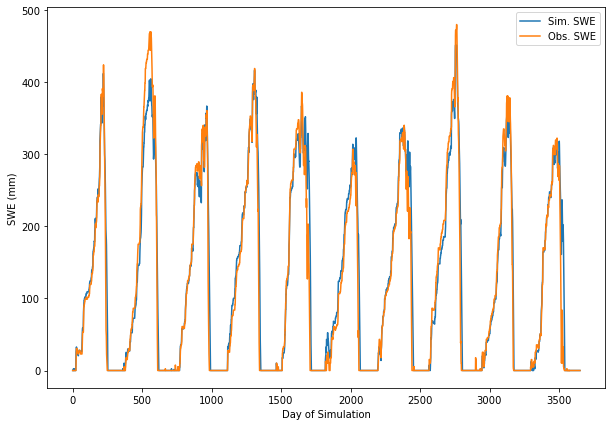

In [35]:
# Plot the simulated and observed SWE
plt.figure(figsize=(10, 7))
plt.plot(swe_output,label='Sim. SWE')
plt.plot(forcing.swe_mm, label='Obs. SWE')
plt.ylabel('SWE (mm)')
plt.xlabel('Day of Simulation')
plt.legend()
plt.show()
plt.close()

All in all, that's a pretty good result for a non-calibrated temperature index snow model that completely ignores snow hydrology and runs on a daily time step. In fact, we can calculate its Nash Sutcliffe efficiency (NSE) and mean bias. 

In [36]:
# Calculate and print NSE
obs = forcing.swe_mm
sim = swe_output
nse_denominator = ((obs - obs.mean())**2).sum()
nse_numerator = ((sim - obs)**2).sum()
nse = 1 - nse_numerator / nse_denominator
print("NSE: {:.2f}".format(nse))

# Calculate mean bias
mean_bias = sim.mean() - obs.mean()
print("Mean bias: {:.2f}".format(mean_bias), "mm")

NSE: 0.94
Mean bias: 4.68 mm


If only all of our models could be so good! Okay, let's end this and finalize our run.

In [37]:
x.finalize()

# 5 Coupling `snowBMI` with `linearresBMI` using BMI commands

We've now run `snowBMI`, which is great, but snow accumulation and melt is only part of the hydrologic balance. What if we also wanted to represent runoff processes by coupling another model to `snowBMI`?

In the past, the coupling process could take weeks to months of refactoring model code and painfully stitching together two independently developed models (if it were possible at all). BMI, yet again, standardizes the process for easy modeling coupling.

Let's demonstrate this now using `linearresBMI`, which is a linear reservoir model to simulate discharge. **Note,** in this case, our linear reservoir assumes all incoming water fluxes exit the model domain as discharge (i.e., we're not representing evapotranspiration or aquifer recharge).

## 5.1 Import the module
We've already imported `os`, `numpy`, `pandas`, `matplotlib`, and `snowBMI`, now we just need `linearresBMI`.

In [38]:
from linearres import LinearresBmi

## 5.2 Initialize

Create an instance of the model's BMI. (We'll also reinitialize `snowBMI` to make sure we're starting fresh.)

In [39]:
x = SnowBmi()
y = LinearresBmi()

Use the BMI `get_component_name` function to query the model's name.

In [40]:
print(x.get_component_name())
print(y.get_component_name())

Temperature Index Snow Model with BMI
Linear Reservoir Model with BMI


Now we'll start both models through using configuration files. We'll just look at the `linearresBMI` config becuase we've already seen the one for `snowBMI`.

In [41]:
cat linearres.yaml

# Linear reservoir model configuration
k: 0.25              # loss factor parameter for linear reservoir
discharge_init: 10 # initial discharge (mm d-1)

Let's initialize both models with their configs.

In [42]:
x.initialize("snow.yaml")
y.initialize("linearres.yaml")

## 5.3 Get info on the models

You can see below that linearresBMI and snowBMI run on the same time step, making coupling straightforward.

In [43]:
print("Time step snowBMI:", x.get_time_step())
print("Time units snowBMI:", x.get_time_units())
print("Time step linearresBMI:", y.get_time_step())
print("Time units linearresBMI:", y.get_time_units())

Time step snowBMI: 86400
Time units snowBMI: s
Time step linearresBMI: 86400
Time units linearresBMI: s


We can also look at the input and output vars.

In [44]:
print("Input vars snowBMI =", x.get_input_var_names())
print("Output vars snowBMI =", x.get_output_var_names())
print("Input vars linearresBMI =", y.get_input_var_names())
print("Output vars linearresBMI =", y.get_output_var_names())

Input vars snowBMI = ('atmosphere_water__precipitation_leq-volume_flux', 'land_surface_air__temperature')
Output vars snowBMI = ('snowpack__liquid-equivalent_depth', 'snowpack__melt_volume_flux')
Input vars linearresBMI = ('atmosphere_water__precipitation_leq-volume_flux',)
Output vars linearresBMI = ('land_surface_water__runoff_volume_flux',)


Interestingly, `snowBMI` and `linearresBMI` both require precipitation as a forcing variable. Does that mean we can just take precip from the `snowBMI` forcing and pipe it into `linearresBMI`? Not exactly.

`linearresBMI` doesn't handle snow accumulation and melt because it assumes all incoming precipitation is liquid. So we need a snow model in this particular location to represent those processes.

What this does mean is that **we can couple the two models by using BMI functions** to pass output data from `snowBMI` to `linearresBMI`, namely *snowpack__melt_volume_flux* to *atmosphere_water__precipitation_leq-volume_flux*.

## 5.4 Run the coupled models

Now that we understand BMI functions and the two models, we can couple them and run them. We'll use the forcing data from the `snowBMI` example and save output data in a new data frame for discharge.

In [45]:
# Make an empty array to store the output data
discharge_output = np.zeros(forcing.date.size)

Now let's run a BMI update loop, passing the data via get and set value.

In [46]:
# Loop through the data and run models
for i in range(forcing.date.size):
    # Get the forcing data
    air_temperature = np.full(1, forcing.tair_c[i])
    precip = np.full(1, forcing.ppt_mm[i])
    # Set the forcing data values in snowBMI 
    x.set_value("land_surface_air__temperature", air_temperature)
    x.set_value("atmosphere_water__precipitation_leq-volume_flux", precip)
    # Update snowBMI
    x.update()
    # Get the melt value from snowBMI and set it as the precip of linearresBMI
    y.set_value("atmosphere_water__precipitation_leq-volume_flux", x.get_value_ptr("snowpack__melt_volume_flux"))
    # Update linearresBMI
    y.update()
    # Save the discharge output
    discharge_output[i] = y.get_value_ptr("land_surface_water__runoff_volume_flux")

## 5.5 Plot the model output

Now we can look at the simulated discharge.

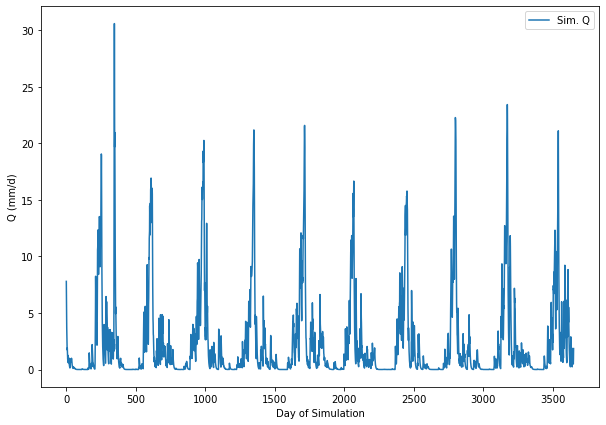

In [47]:
# Plot the simulated and observed SWE
plt.figure(figsize=(10, 7))
plt.plot(discharge_output,label='Sim. Q')
plt.ylabel('Q (mm/d)')
plt.xlabel('Day of Simulation')
plt.legend()
plt.show()
plt.close()

In [48]:
# And finalize the models
x.finalize()
y.finalize()

# 6 Wrap-Up

That about does it. In this notebook, we:

1. Learned how to access and set up the `snowBMI` and `linearresBMI` models
2. Got an introduction to BMI functions and their implementation
3. Ran a single model with BMI commands
4. Coupled two models using BMI commands

Feel free to contact me using the resources up top if you have any questions (or if you see any bugs in the code). Until we meet again, please take a look through the BMI and NextGen references below. Thanks! 

# References and further reading (and watching)

- [BMI](https://csdms.colorado.edu/wiki/BMI) from CSDMS
- The BMI Python [heat](https://github.com/csdms/bmi-example-python) example
- *Hutton, E.W., Piper, M.D., and Tucker, G.E., 2020. The Basic Model Interface 2.0: A standard interface for coupling numerical models in the geosciences. Journal of Open Source Software, 5(51), 2317, https://doi.org/10.21105/joss.02317.*
- *Peckham, S.D., Hutton, E.W., and Norris, B., 2013. A component-based approach to integrated modeling in the geosciences: The design of CSDMS. Computers & Geosciences, 53, pp.3-12, http://dx.doi.org/10.1016/j.cageo.2012.04.002.*
- Temperature index snow models like Snow-17 and the equations in DeWalle and Rango (2008)
    - _Anderson, E. A. "Snow accumulation and ablation model–SNOW-17." US National Weather Service, Silver Spring, MD 61 (2006)._
    - _DeWalle, David R., and Albert Rango. Principles of Snow Hydrology. Cambridge University Press, 2008._
- Wikipedia's entry on [runoff models](https://en.wikipedia.org/wiki/Runoff_model_(reservoir)) (yes, that Wikipedia)
    - The linear reservoir equation cites this document: *J.W. de Zeeuw, 1973. Hydrograph analysis for areas with mainly groundwater runoff. In: Drainage Principle and Applications, Vol. II, Chapter 16, Theories of field drainage and watershed runoff. p 321-358. Publication 16, International Institute for Land Reclamation and Improvement (ILRI), Wageningen, The Netherlands.* (good luck finding it!)
- The Next Generation Water Prediction Capability project at the NOAA-NWS Office of Water Prediction
   - GitHub repo for the [NextGen Framework](https://github.com/NOAA-OWP/ngen)
   - BMI implementation of the [LSTM](https://github.com/NOAA-OWP/lstm/) machine learning model
   - [CUAHSI Town Hall with NOAA’s National Water Center](https://www.youtube.com/watch?v=pPUyhmj2mFM)
